In [1]:
from scipy.io import loadmat
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
from sklearn.svm import SVC
%matplotlib inline

In [3]:
_,_,_,X_trn_data1, X_tst_data1, Y_trn_data1, Y_tst_data1 = loadmat('data/data1.mat').values()
_,_,_,X_trn_data2, X_tst_data2, Y_trn_data2, Y_tst_data2 = loadmat('data/data2.mat').values()

### SVM Implementation -- SMO

In [4]:
class SimplifiedSMO():
    def __init__(self):
        return None
    def __COMPUTEERROR__(self,X,Y,alpha,i,b):
        f_xi = sum([(alpha[j]*Y[j]*np.dot(X[j].T,X[i])) for j in range(len(X))])+b
        error = f_xi-Y[i]
        return error
    def train(self,X,Y,maxPasses,C,tol):
        Y_new=np.array([np.array([x]) if x==1 else -1 for x in Y])#algorithm only works with 1 and -1
        #normalize data
        X_copy = np.copy(X) #create a copy of the data
        for i in range(len(X_copy[0])):
            #for all col i in X get the mean and standard deviation
            col=np.array([[X_copy[j][i]] for j in range(len(X_copy))])
            col_mean=np.mean(col) 
            col_std = np.std(col)
            for j in range(len(X_copy)):
                if col_std!=0:
                    X_copy[j][i]=(X_copy[j][i]-col_mean)/col_std #scale data to prevent theta overflow
                else:
                    X_copy[j][i]-(X_copy[j][i]-col_mean)
        
        #SMO Algorithm
        alphaVector = np.array([0]*len(X_copy))#initialize all 0
        b = 0
        passes = 0
        while passes < maxPasses:
            num_changed_alphas = 0
            for i in range(len(X_copy)):
                Error_i =self.__COMPUTEERROR__(X_copy,Y_new,alphaVector,i,b)#E_i = f(x_i) - y_i
                if (Y_new[i]*Error_i<-tol and alphaVector[i]<C) or (Y_new[i]*Error_i>tol and alphaVector[i]>0):
                    j = random.choice([j for j in range(len(X_copy)) if j!=i])
                    Error_j =self.__COMPUTEERROR__(X_copy,Y_new,alphaVector,j,b)
                    
                    #set to old variable for operations later
                    alpha_iOld = alphaVector[i]
                    alpha_jOld = alphaVector[j]
                    
                    #setting upper and lower bounds
                    if Y_new[i]==Y_new[j]:
                        L = max(0,alphaVector[i]+alphaVector[j]-C)
                        H = min(C, alphaVector[i]+alphaVector[j])
                    else:
                        L = max(0,alphaVector[j]-alphaVector[i])
                        H = min(C, C+alphaVector[j]-alphaVector[i])
                    if L==H:
                        continue
                    eta = (2*np.dot(X_copy[i].T,X_copy[j])) - np.dot(X_copy[i].T,X_copy[i]) - np.dot(X_copy[j].T,X_copy[j])
                    if eta >= 0:#we want eta to be negative
                        continue
                    alpha_j = alphaVector[j] - ((Y_new[j]*(Error_i-Error_j))/eta) #alpha_j may be set to alphaVector[j]
                    if alpha_j>H:
                        alphaVector[j]=H
                    elif alpha_j<L:
                        alphaVector[j]=L
                    else:
                        alphaVector[j]=alpha_j
                    if np.abs(alphaVector[j]-alpha_jOld)<10**-5:
                        continue
                    alphaVector[i]=alphaVector[i] + (Y_new[i]*Y_new[j] * (alpha_jOld - alphaVector[j]))
                    b_1 = b - Error_i - Y_new[i]*(alphaVector[i]-alpha_iOld)*np.dot(X_copy[i].T,X_copy[i]) - Y_new[j]*(alphaVector[j]-alpha_jOld)*np.dot(X_copy[i].T,X_copy[j])
                    b_2 = b - Error_j - Y_new[i]*(alphaVector[i]-alpha_iOld)*np.dot(X_copy[i].T,X_copy[j]) - Y_new[j]*(alphaVector[j]-alpha_jOld)*np.dot(X_copy[j].T,X_copy[j])

                    if 0<alphaVector[i]<C:
                        b = b_1
                    elif 0<alphaVector[j]<C:
                        b = b_2
                    else:
                        b = (b_1+b_2)/2
                    num_changed_alphas+=1
            if num_changed_alphas==0:
                passes+=1
            else:
                passes=0
        w = np.sum(np.array([alphaVector[i]*Y_new[i]*X_copy[i] for i in range(len(X_copy))]),axis=0)
        return np.reshape(w,newshape=(2,1)), b
    def test(self,X,w,b):
        X_copy = np.copy(X) #create a copy of the data
        for i in range(len(X_copy[0])):
            #for all col i in X get the mean and standard deviation
            col=np.array([[X_copy[j][i]] for j in range(len(X_copy))])
            col_mean=np.mean(col) 
            col_std = np.std(col)
            for j in range(len(X_copy)):
                if col_std!=0:
                    X_copy[j][i]=(X_copy[j][i]-col_mean)/col_std #scale data to prevent theta overflow
                else:
                    X_copy[j][i]-(X_copy[j][i]-col_mean)
        y_hyper = np.dot(X_copy,w)+b
        y_pred = [1 if x>0 else 0 for x in y_hyper]
        return y_pred

### Helper Functions

In [5]:
#classification error
def classificationError(y_pred,y_true):
    '''
    number wrong/total number of samples'''
    wrong = 0
    total = len(y_true)
    for i in range(len(y_pred)):
        if y_pred[i]!=y_true[i]:
            wrong+=1
    return wrong/total 

#grid search for SVM
def gridSearchSMO(X_trn, Y_trn, X_tst, Y_tst,params):
    '''
    Conducts a grid search of all important parameters. Parameters is a dictionary.
    '''
    error = 1000
    for param in params: #train and test model using all combinations of hyperparameters
        for v in params[param]:
            model = SimplifiedSMO()
            w,b = model.train(X_trn,Y_trn,100,v,0.001)
            y_pred = model.test(X_tst,w,b)
            temp = classificationError(y_pred,Y_tst)
            if error> temp: #if the current error is better than previous error update best hyperparameters
                error = temp
                best_C = v
    return best_C

#k fold for SMO
def kFoldCVSMO(k,X,Y):
    '''
    Function that allows for k-fold cross validation. K-fold cross validation a way to a train a classifier by 
    making k partitions of the data. Then it takes these k partitions and then for each partition, it makes that
    a hold-out set and the rest of the data a training set. It takes the best parameters based on each partition via
    a grid search and then gets the average of the hyperparameters.
    '''
    random.seed(141)
    
    #shuffle both X and Y
    indices = list(range(len(X)))
    random.shuffle(indices)
    X_copy=np.copy(X)[indices]
    Y_copy=np.copy(Y)[indices]
    
    lenPartitions = len(X_copy)//k #the size of each partition
    best_params = []
    for part in range(k):
        start = part*lenPartitions
        end = (part+1)*lenPartitions
        holdOutIndices = list(range(start,end)) #define hold out set as set from set start to end index
        restIndices = list(set(range(len(X_copy))).difference(set(holdOutIndices))) #anything not in the hold out set defined here
        
        #create hold out set and training set
        X_train = X_copy[restIndices]
        Y_train = Y_copy[restIndices]
        X_test = X_copy[holdOutIndices]
        Y_test = Y_copy[holdOutIndices]
        
        #update best params so that we can average of both hyperparameters
        best_params.append(gridSearchSMO(X_train,Y_train,X_test,Y_test,{'C':[1,2,3]}))
    avgC = np.mean([x for x in best_params])
    return avgC

#plot effect of C
def effectOfC(X_trn,Y_trn,X_tst,Y_tst,C_list):
    trainError = []
    testError = []
    for C in C_list:
        model = SimplifiedSMO()
        w,b = model.train(X_trn,Y_trn,100,C,0.001)
        y_pred_train = model.test(X_trn,w,b)
        y_pred = model.test(X_tst,w,b)
        trainError.append(classificationError(y_pred_train,Y_trn))
        testError.append(classificationError(y_pred,Y_tst))
        print(C)
    f, axarr = plt.subplots(2,sharex=True)
    f.suptitle('Effects of Regularization Constant C on Error')
    axarr[0].plot(C_list,trainError,label='train')
    axarr[0].legend()
    axarr[1].plot(C_list,testError,label='test')
    axarr[1].legend()
    f.text(0.5, 0, 'C', ha='center')
    f.text(0, 0.5, 'Classification Error', va='center', rotation='vertical')

def effectOfC_RealSVM(X_trn,Y_trn,X_tst,Y_tst,C_list):
    trainError = []
    testError = []
    for C in C_list:
        model = SVC(kernel='linear',C=C)
        model.fit(X_trn,Y_trn)
        y_pred_train = model.predict(X_trn)
        y_pred = model.predict(X_tst)
        trainError.append(classificationError(y_pred_train,Y_trn))
        testError.append(classificationError(y_pred,Y_tst))
        print(C)
    f, axarr = plt.subplots(2,sharex=True)
    f.suptitle('Effects of Regularization Constant C on Error (sklearn)')
    axarr[0].plot(C_list,trainError,label='train')
    axarr[0].legend()
    axarr[1].plot(C_list,testError,label='test')
    axarr[1].legend()
    f.text(0.5, 0, 'C', ha='center')
    f.text(0, 0.5, 'Classification Error', va='center', rotation='vertical')

### Dataset 1

In [6]:
model = SimplifiedSMO()
w,b = model.train(X_trn_data1,Y_trn_data1,100,1,0.001)
y_pred = model.test(X_tst_data1,w,b)
classificationError(y_pred,Y_tst_data1)

0.0

In [7]:
C = kFoldCVSMO(3,X_trn_data1,Y_trn_data1)
model = SimplifiedSMO()
w,b = model.train(X_trn_data1,Y_trn_data1,100,C,0.001)
y_pred = model.test(X_tst_data1,w,b)
classificationError(y_pred,Y_tst_data1)

0.0

In [8]:
model = SVC(kernel='linear',)
model = model.fit(X_trn_data1,Y_trn_data1)
print(model)
y_pred=model.predict(X_tst_data1)
classificationError(y_pred,Y_tst_data1)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


C:\Users\ibiyt\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0

C:\Users\ibiyt\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1
2
3


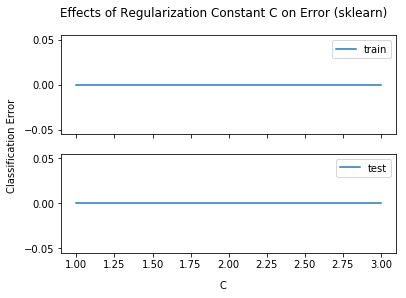

In [9]:
effectOfC_RealSVM(X_trn_data1,Y_trn_data1,X_tst_data1,Y_tst_data1,[1,2,3])

1
2
3


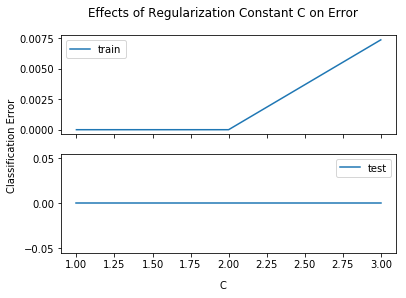

In [10]:
effectOfC(X_trn_data1,Y_trn_data1,X_tst_data1,Y_tst_data1,[1,2,3])

### Dataset 2

C:\Users\ibiyt\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1
2
3


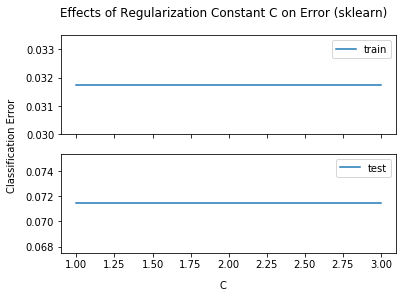

In [11]:
effectOfC_RealSVM(X_trn_data2,Y_trn_data2,X_tst_data2,Y_tst_data2,[1,2,3])

In [ ]:
effectOfC(X_trn_data2,Y_trn_data2,X_tst_data2,Y_tst_data2,[1,2,3])

What we see for both A and B, the test classification error is constant (for A it was 0.0 and for B is was roughly 0.072.) For part A the training classification error remains constant at C=1 and 2 and then drops at C=3; whereas, in part B there is a drop in error from C=1 and C=2 and then it remains constant from C=2 to C=3. 

It seems that there a few data points that might be classified as one group but they are close to the optimal hyperplane and are being incorrectly classified in part B. We see this due to the low classification error, whereas in part A, the data is perfectly seperated in the test set.

It seemed that in the actual implementation of SVM the affect of C had little affect on the training error.